### Self-supervised Learning of Visual Representations

In this tutotial, you will investigate two popular self-supervised strategies for learning visual representations. In particular, you will reproduce results from the following seminal papers:

* Caron, M., Bojanowski, P., Joulin, A., & Douze, M. (2018). **Deep clustering for unsupervised learning of visual features**. In Proceedings of the European conference on computer vision (ECCV) (pp. 132-149),
  
* Chen, T., Kornblith, S., Norouzi, M., & Hinton, G. (2020, November). **A simple framework for contrastive learning of visual representations**. In International conference on machine learning (pp. 1597-1607). PmLR.

Both methods aim to learn task-agnostic features from an unsupervised data set by minimizing a self-supervised loss function.

#### Structure of the repo

The code for running this tutorial is available at https://github.com/Romain3Ch216/DL4IA/tree/main/docs/tutorials/learning_visual_representations. We suggest to fork the [DL4IA](https://github.com/Romain3Ch216/DL4IA) repo and clone your fork:
```
git clone git@github.com:<your-username>/DL4IA.git

```

The repo contains the following files, with code **to be completed**.
```
learning_visual_representations
├── configs
    ├── dc_exp.yaml
    ├── ...
├── learning
    ├── transformations.py
    ├── nce_loss.py
├── models
    ├── alexnet.py
    ├── projection_head.py
├── util_scripts
├── activations.py
├── contrastive_training.py
├── datasets.py
├── dc_exp.py
├── imagenet_mnist_exp.py
├── learning_visual_representations.ipynb
├── utils.py
```

#### 1. Deep Clustering

The Deep Clustering (DC) algorithm is based on the assumption that convolutional layers provide a strong prior on the input signal. The authors base their intuition on an empirical result obtained by [Noroozi et al. (2016)](https://www.researchgate.net/profile/Mehdi-Noroozi-2/publication/301837491_Unsupervised_Learning_of_Visual_Representations_by_Solving_Jigsaw_Puzzles/links/58385c8808aed5c614885771/Unsupervised-Learning-of-Visual-Representations-by-Solving-Jigsaw-Puzzles.pdf) who observed that "a multilayer perceptron classifier on top of the last convolutional layer of a random AlexNet [a CNN] achieves 12% in accuracy on ImageNet while the chance is at 0.1%". Therefore, the goal of the Deep Clustering algorithm is to "exploit this weak signal to bootstrap the discriminative power of a convnet".

Let's verify this result ourself! As in the paper, we are going to use the famous [ImageNet](https://image-net.org/) dataset, or at least a small subset of it, and the convolutional network [AlexNet](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf).

In [1]:
import random
import numpy as np
import torch

# Pour rendre le notebook reproductible 
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

#  Si CUDA est utilisé /!\ ralentissement des performances possible /!\
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False


In [2]:
import yaml
import matplotlib.pyplot as plt

from models.alexnet import alexnet
from datasets import SubsetImageNet
import utils

In [3]:
with open('configs/dc_exp.yaml', 'r') as file:
    cfg = yaml.safe_load(file)

subset_classes = cfg['subset_classes']

dataset = SubsetImageNet(
    cfg['data_folder'], 
    cfg['labels_file'], 
    classes=subset_classes
    )

First, let's take a look at the dataset.

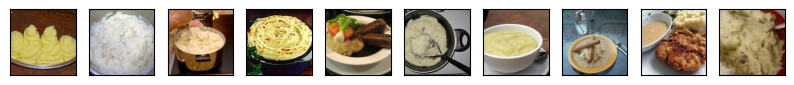

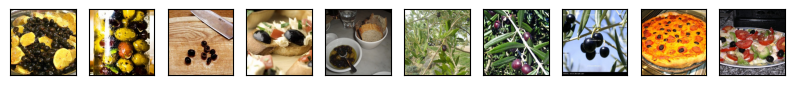

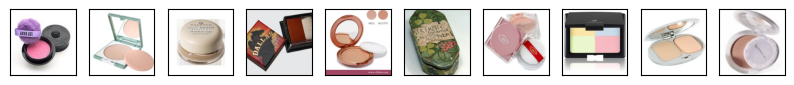

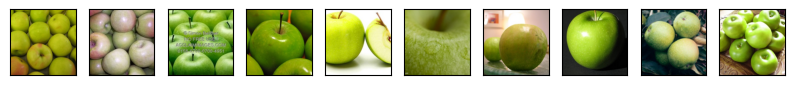

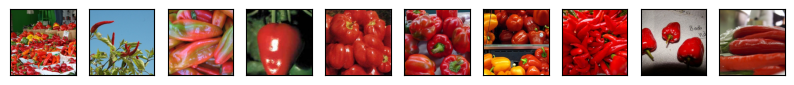

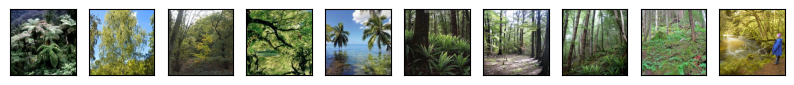

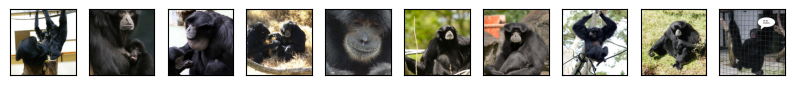

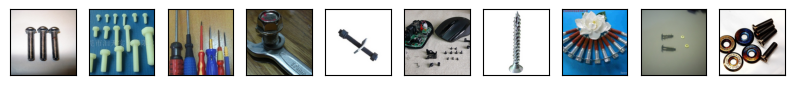

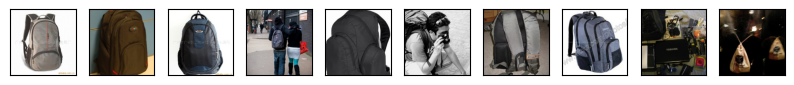

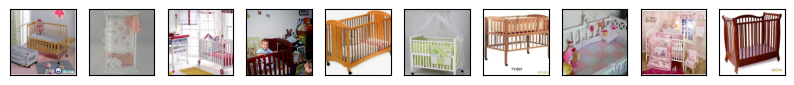

In [4]:
data, labels = utils.dataset2tensor(dataset)
#print(data.shape)
data = data.permute(0, 2, 3, 1)
for class_id in range(len(subset_classes)):
    utils.show_samples_per_class(data, labels, class_id, n_samples=10, figsize=(10, 30))

Now, let's visualize the filters of the first layer of an AlexNet at initialization. Can those random filters still extract useful features for classification?

In [5]:
model = alexnet(out = 10)
conv1 = model.features[0]
conv1 = conv1.weight.data.cpu().numpy()

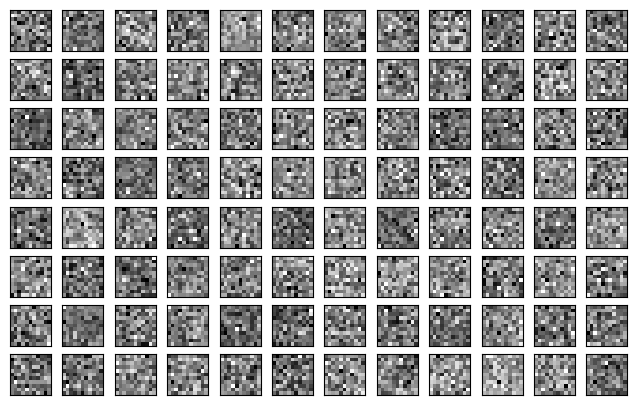

In [6]:
fig, ax = plt.subplots(8, 12, figsize=(8, 5))
for i in range(conv1.shape[0]):
    ax[i // 12, i %12].imshow(conv1[i, 0], cmap='gray')
    ax[i // 12, i %12].set_xticks([])
    ax[i // 12, i %12].set_yticks([])
plt.show()

En visualisant les filtres de convolution de la première couche d’AlexNet avant entraînement, on observe un aspect proche du bruit gaussien, ce qui est cohérent avec une initialisation aléatoire des poids.

Il est également possible de visualiser les filtres des couches de convolution suivantes (en tenant compte de leur indexation dans le modèle), qui présentent la même nature aléatoire, avec des variations de dimensions conformément à l’architecture du réseau.

Notons que la visualisation suivante ne présente pas de grand intérêt si ce n'est de se rappeller de la structure d'AlexNet.

In [7]:
model.features

Sequential(
  (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding

In [8]:
conv2 = model.features[4]
conv2 = conv2.weight.data.cpu().numpy()

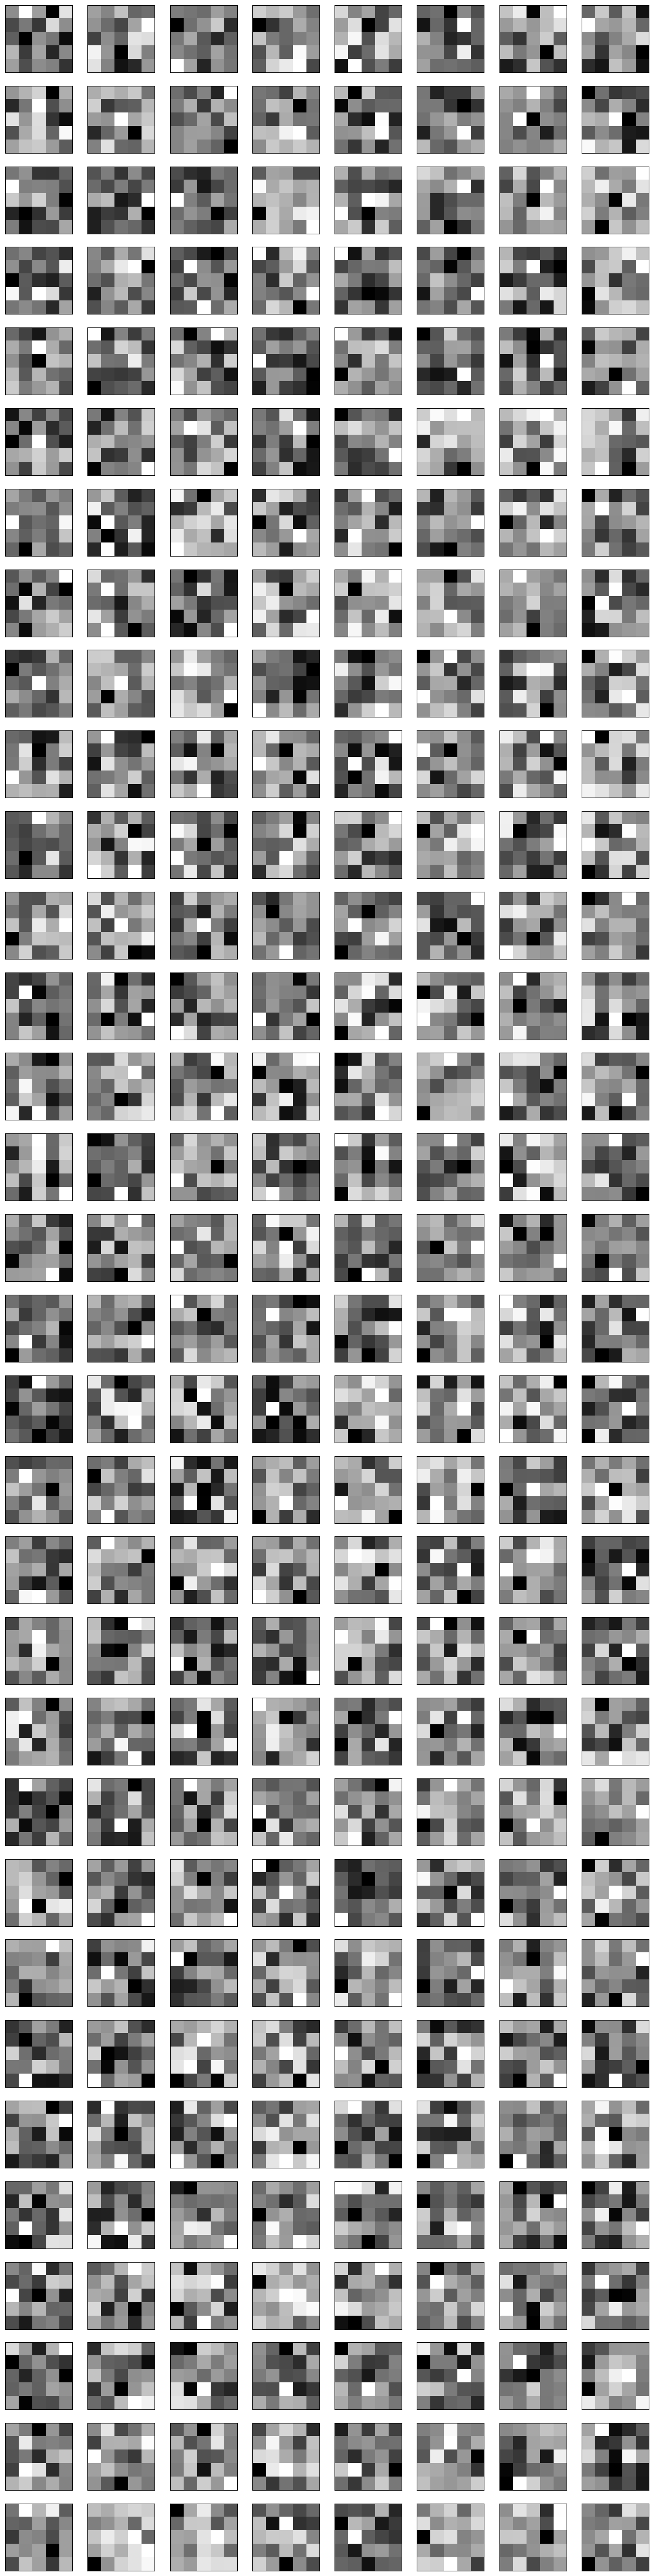

In [9]:
fig, ax = plt.subplots(32, 8, figsize=(16, 64))

for i in range(conv2.shape[0]):
    ax[i // 8, i %8].imshow(conv2[i, 0], cmap='gray')
    ax[i // 8, i %8].set_xticks([])
    ax[i // 8, i %8].set_yticks([])
plt.show()

#### 1.1 "Convolutional layers provide a strong prior on the input signal"

We're going to reproduce the experiment of Noroozi et al. (2016) on our subset of ImageNet. Update the `freeze_feature_layers` in the `AlexNet` class to freeze its convolutional layers. Run the `test_dc_assumption.py` script. **Is the model better than a random guess on the test set?**

In [ ]:
# Pour lancer l'entrainement depuis le notebook 
# /!\ les logs n'apparaissent pas /!\
!python dc_exp.py --cfg_file configs/dc_exp.yaml


In [11]:
from collections import Counter

labels = [label for _, label in dataset]
counter = Counter(labels)

for cls, count in counter.items():
    print(f"Classe {cls}: {count}")


Classe 3: 50
Classe 7: 50
Classe 1: 50
Classe 4: 50
Classe 6: 50
Classe 0: 50
Classe 9: 50
Classe 8: 50
Classe 5: 50
Classe 2: 50


Ici, on entraîne le modèle pour estimer ses performances.
On rappelle que les couches de convolution (que nous appellerons backbone pour simplifier le propos) sont figées, c’est-à-dire qu’elles conservent leur initialisation aléatoire et ne sont pas entraînées par descente de gradient. Seule la couche finale du classifieur dense est entraînée.

Par souci d’économie de temps et par manque de ressources computationnelles, l’entraînement est arrêté manuellement depuis la console dès que les performances du modèle sur le jeu de validation dépassent une accuracy de 0,1. Cela se produit dès les premières époques. On considère alors que les capacités prédictives du modèle dépassent celles d’une baseline naïve (prédiction aléatoire d’un des labels parmi les 10 conservés).

Notons que cette baseline n’est valable que si le jeu de données est équilibré. C’est pourquoi la cellule précédente calcule la proportion de chaque classe dans le dataset, ce qui confirme que la baseline choisie est valide.

On obtient un résultat cohérent avec ceux observés par *Noroozi et al. (2016)*. Même avec des poids aléatoires, le backbone d’AlexNet permet d’obtenir de meilleures performances en classification que le hasard. Cela suggère que le fonctionnement intrinsèque des couches de convolution permet de résumer l’information contenue dans les images. On peut penser que c’est la capacité à regrouper des zones complètes de l’image et à introduire une certaine invariance spatiale qui explique ce gain d’information.

#### 1.2 Visualization of the convolutional filters

Now, we are going to try to analyse the features learned through Deep Clustering. Specifically, you are going to reproduce figures of the paper that visualise the convolutional filters. Let's load the pretrained weights of AlexNet trained by DC.

##### 1.2.1 First layer

In [12]:
import torch
#import torchvision.transforms.v2 as T

In [13]:
# Ici il faut charger un modèle avec le même nombre de classe que lors de l'entrainement du modèle
model = alexnet(out = 10000, sobel=True, freeze_features = True) 

pretrained_params = torch.load("C:/Users/Lenovo/IODAA/data_TD3/data_td3/pretrained_alexnet_dc.tar", 
                                map_location=torch.device('cpu')
                               )
model.load_state_dict(pretrained_params)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(2, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d

Visualize the filters of the first layer, as above, and as in the right part of Fig. 3 in the paper. What kind of features do those filters extract?

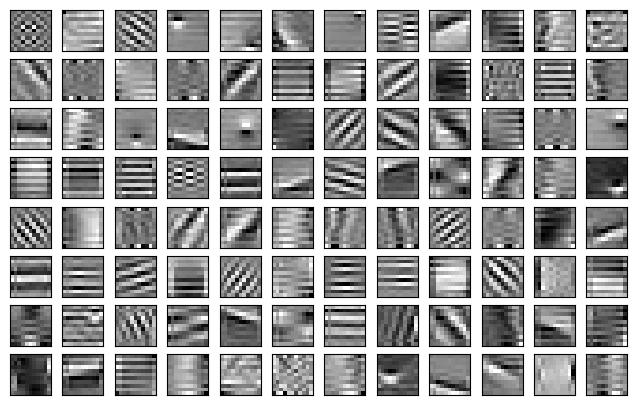

In [14]:
conv1 = model.features[0].weight.data.cpu().numpy()

fig, ax = plt.subplots(8, 12, figsize=(8, 5))
for i in range(conv1.shape[0]):
    ax[i // 12, i %12].imshow(conv1[i, 1], cmap='gray')
    ax[i // 12, i %12].set_xticks([])
    ax[i // 12, i %12].set_yticks([])
plt.show()

Les filtres de la première couche de convolution ont une structure relativement simple, généralement strié selon un angle fixe (alternance de valeurs proches de 1 et de valeurs proches de 0), avec pour certains un effet de flou.

Ces filtres permettent de détecter des motifs généraux, comme les contours d’objets par exemple.
Les variations de fréquence de la répétition du motif strié permettent de détecter les contours d’objets de taille variable.
L’effet de "flou" délimite les zones qui sont prises en compte par le filtre. Elles déterminent des zones qui "ne sont pas regardées par le filtre".

L’angle des stries détermine l’orientation du contour détecté : des stries verticales permettent de détecter des variations nettes selon l’axe horizontal. On peut imaginer un exemple grossier où ce genre de filtre permettrait de détecter, par exemple, des mâts de bateau sur une image.

##### 1.2.2 Probing deeper layers

Would it make sense to visualize the filters of the deeper layers as we have done for the first layer? Let's reproduce the Fig. 5 of the paper:

* compute the activations of the last layer of the convnet for every sample in the dataset,

* show the top-10 images that are activated by the filters 0 and 33.

In Fig. 5 of the paper, what kind of images mostly activate the filters 0 and 33? Is it consistent with your results?

Note: If a convolutional layer outputs a (n_channel x height x width) tensor, the activation is defined as the average over the spatial dimensions, leading to a n_channel-dimensional tensor.



Les filtres des couches plus profondes combinent les filtres des couches précédentes. Plus les couches sont profondes, moins elles sont interprétables par une simple visualisation des poids des couches. Il est plus simple de visualiser des cartes d’activation ou de chercher les images qui activent le plus ces filtres afin de comprendre leur spécialisation. C’est ce que nous allons faire dans la suite de ce TD.

In [15]:
from activations import compute_dataset_activations

In [16]:
import torchvision.transforms as transforms

transformations = {
    'center_crop': transforms.CenterCrop(224),
    'normalize': transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  
        std=[0.229, 0.224, 0.225]
    ),
}

dataset.transform = transforms.Compose(
    [transformations[k] for k in cfg['transforms']]
    )

In [17]:
activations = compute_dataset_activations(model, dataset, layer=5)

Compute activations over dataset for layer 5: 100%|██████████| 8/8 [00:41<00:00,  5.22s/it]


In [18]:
activations.shape

torch.Size([500, 256])

In [19]:
top10_activations_f0 = activations[:, 0].argsort(descending=True)[:10]
top10_activations_f33 = activations[:, 33].argsort(descending=True)[:10]

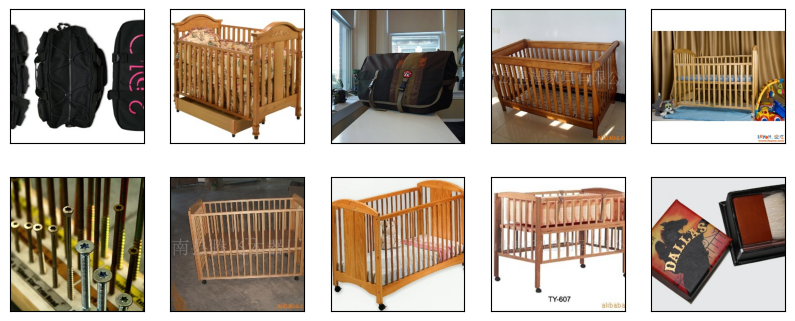

In [20]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
dataset.transform = None
for i, sample_id in enumerate(top10_activations_f0):
    img, _ = dataset.__getitem__(sample_id)
    img = img.permute(1, 2, 0)
    ax[i // 5, i % 5].imshow(img)
    ax[i // 5, i % 5].set_xticks([])
    ax[i // 5, i % 5].set_yticks([])
plt.show()

L’analyse est assez grossière pour l’instant, mais on remarque que l’un des points communs de la plupart de ces images est la répétition d’une structure régulière sur un fond assez clair.
A priori, le filtre 5 semble spécialisé dans la détection de structures répétitives selon l’axe horizontal.

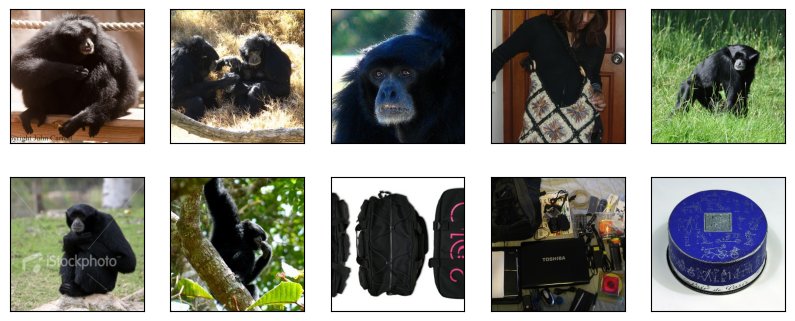

In [21]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
dataset.transform = None
for i, sample_id in enumerate(top10_activations_f33):
    img, _ = dataset.__getitem__(sample_id)
    img = img.permute(1, 2, 0)
    ax[i // 5, i % 5].imshow(img)
    ax[i // 5, i % 5].set_xticks([])
    ax[i // 5, i % 5].set_yticks([])
plt.show()

Ici, il s’agirait plutôt de la détection d’une structure plus ou moins globulaire et sombre.

Notons qu’il faut rester prudent dans l’interprétation de ces images. Elle reste subjective et dépend de l’utilisateur, des points communs ou différences qui lui sautent aux yeux. C’est bien là la difficulté liée au vision computing et à l’introspection des modèles, où l’on cherche à appliquer un raisonnement humain à la machine.

Another way to "visualize" deeper layers is to find images that maximize the response to a convolutional filter. In ["Understanding Neural Networks Through Deep Visualization"](https://arxiv.org/pdf/1506.06579), Yosinski et al. introduce an optimization algorithm in image space with a regularization to produce recognizable and interpretable vizualizations.

In [22]:
from activations import maximize_img_response

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
max_img_f0 = maximize_img_response(model, device=device, n_it=50000, img_size=224, layer=5, filter_id=0)
max_img_f145 = maximize_img_response(model, device=device, n_it=50000, img_size=224, layer=5, filter_id=33)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(max_img_f0)
ax[1].imshow(max_img_f145)
plt.show()

Are those images interpretable? Are there consistent with the images above that activate the filters the most?

Ces images ne sont pas facilement interprétables. Toutefois, pour le filtre 0, on observe une structure légèrement striée horizontalement, ce qui est cohérent avec nos conclusions précédentes. Pour le filtre 145, elle diffère de celle étudiée précédemment, donc aucune conclusion n’est possible.

#### 2. Contrastive Learning

As we have seen, the high-level idea of contrastive learning (CL) is to maximize the similarity of different views of the data in the latent space. One seminal CL algorithm, named simCLR, was introduced in (Chen et al., 2020), illustrated in the figure below, taken from the original article:
<center>
   <img alt="fig_contrastive" src="figures/fig_contrastive.png" width=300> 
</center>
<center>
    Source: <a href="https://proceedings.mlr.press/v119/chen20j/chen20j.pdf">https://proceedings.mlr.press/v119/chen20j/chen20j.pdf</a>
</center>
In this tutorial, we are going to use AlexNet as the base encoder $f(\cdot)$, and a MLP with one hidden layer as the projection head $g(\cdot)$. Regarding the transformations, we will sample a transformation $t$ from a sequence of random cropping with resizing, color distortion, Gaussian blur and normalization. The sequence is fixed, but the transformations themselves are random.

In [25]:
from datasets import ContrastiveDataset
from learning.transformations import DataTransformation
from utils import deprocess_image

In [26]:
with open('configs/contrastive_training.yaml', 'r') as file:
    cfg = yaml.safe_load(file)

transform = DataTransformation(cfg)

dataset = ContrastiveDataset(
    cfg['data_folder'], 
    cfg['labels_file'], 
    classes=cfg['subset_classes'],
    transform=transform()
    )

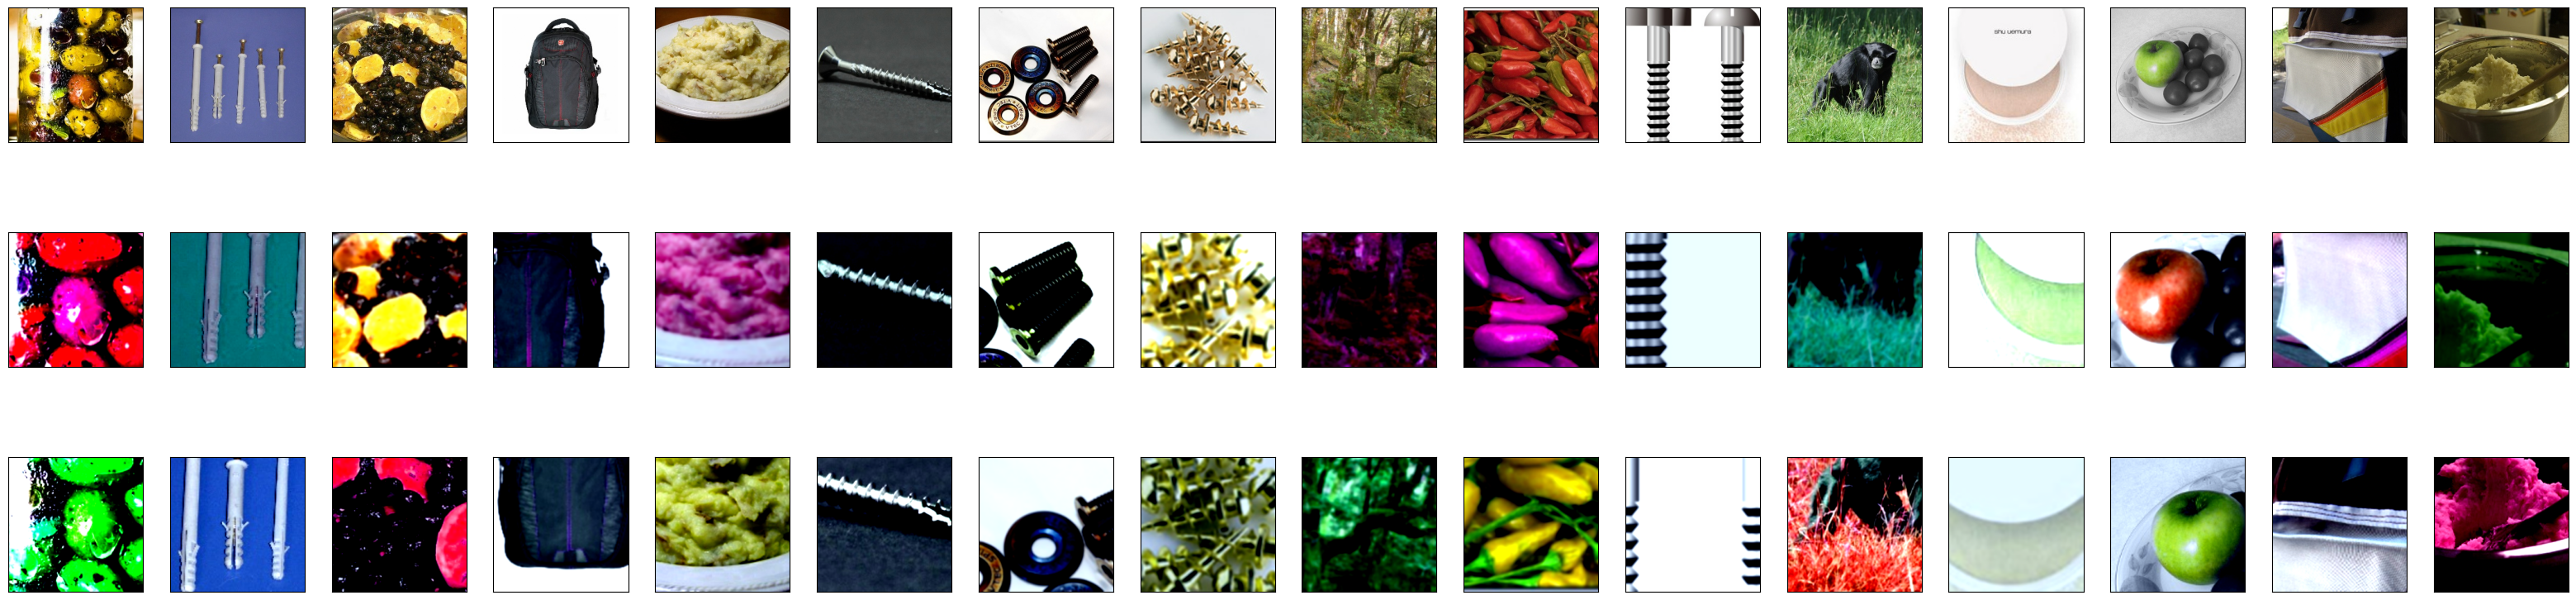

In [27]:
torch.manual_seed(3)

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=16,
    shuffle=True
)

batch = next(iter(data_loader))
imgs, imgs1, imgs2 = batch

fig, ax = plt.subplots(3, imgs.shape[0], figsize=(40, 10))
for i in range(imgs.shape[0]):
    ax[0, i].imshow(imgs[i].permute(1, 2, 0))
    ax[1, i].imshow(deprocess_image(imgs1[i], cfg['data_mean'], cfg['data_std']))
    ax[2, i].imshow(deprocess_image(imgs2[i], cfg['data_mean'], cfg['data_std']))
    for j in range(3):
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
plt.show()

If we would compute features with AlexNet pretrained with Deep Clustering, how similar or dissimilar would those different views of the data be?

NB: je ne suis pas sure d'avoir compris la question...j'ai tenté quelque chose qui tend vers le résultats attendus.

In [28]:
# Ici il faut charger un modèle avec le même nombre de classe que lors de l'entrainement du modèle
model = alexnet(out = 10000, sobel=True, freeze_features = True) 

pretrained_params = torch.load("C:/Users/Lenovo/IODAA/data_TD3/data_td3/pretrained_alexnet_dc.tar", 
                                map_location=torch.device('cpu')
                               )
model.load_state_dict(pretrained_params)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(2, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d

In [29]:
with torch.no_grad():
    h1 = model.sobel(imgs1) if model.sobel else imgs1   
    h1 = model.features(h1)
    h1 = h1.view(h1.size(0), -1)        
    h1 = model.classifier(h1)           

    h2 = model.sobel(imgs2) if model.sobel else imgs2
    h2 = model.features(h2)
    h2 = h2.view(h2.size(0), -1)
    h2 = model.classifier(h2)


In [30]:
import torch.nn.functional as F

h1_norm = F.normalize(h1, dim=1)
h2_norm = F.normalize(h2, dim=1)

sims = torch.mm(h2_norm, h1_norm.T)  


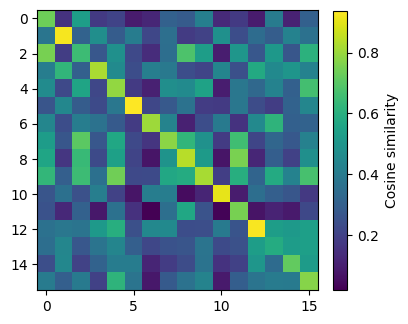

tensor([ 0,  1,  0,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])


In [31]:
fig = plt.figure(figsize=(4, 4))
plt.imshow(sims.cpu())
plt.colorbar(label='Cosine similarity', fraction=0.045)
plt.show()
print(torch.argmax(sims, dim=1))

#### 2.1. SimCLR learning algorithm

Now, let's implement the simCLR algorithm, detailed in Algorithm 1 of the [paper](https://proceedings.mlr.press/v119/chen20j/chen20j.pdf). In order to compute the loss efficiently, we are going to concatenate $z_1$ and $z_2$ (of size N x d), and compute the pairwise similarity in a (2N x 2N) matrix, as illustrated below. In order to compute the cost function $l(i,j)$, we will use the PyTorch cross entropy loss. To discard the $k = i$ terms in the denominator of the cost function $l(i,j)$, *i.e.* the diagonal elements of the similarity matrix, we will set the diagonal terms equal to a very large negative value. 

<center>
    <img alt="matrix_similarity" src="figures/sim.png" width=300>
</center>

Train AlexNet with SimCLR, starting from the pretrained DC parameters at initialization, except for the last layer that outputs 10000-dimensional features. Replace this last dense layer in order to output d_model-dimensional features.

In [32]:
model = alexnet(out = 10000, sobel=True, freeze_features = True) 

pretrained_params = torch.load("C:/Users/Lenovo/IODAA/data_TD3/data_td3/best_model_contrastive.pth.tar", 
                                map_location=torch.device('cpu')
                               )
model.load_state_dict(pretrained_params)
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Lenovo/IODAA/data_TD3/data_td3/best_model_contrastive.pth.tar'

In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(2, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d

In [ ]:
with torch.no_grad():
    h1 = model.sobel(imgs1) if model.sobel else imgs1   
    h1 = model.features(h1)
    h1 = h1.view(h1.size(0), -1)        
    h1 = model.classifier(h1)           

    h2 = model.sobel(imgs2) if model.sobel else imgs2
    h2 = model.features(h2)
    h2 = h2.view(h2.size(0), -1)
    h2 = model.classifier(h2)


In [ ]:
import torch.nn.functional as F

h1_norm = F.normalize(h1, dim=1)
h2_norm = F.normalize(h2, dim=1)

contrastive_sim = torch.mm(h2_norm, h1_norm.T)  

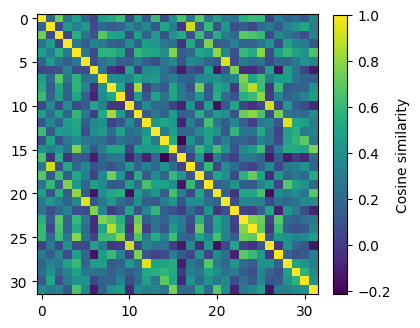

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [ ]:
fig = plt.figure(figsize=(4, 4))
plt.imshow(contrastive_sim.cpu())
plt.colorbar(label='Cosine similarity', fraction=0.045)
plt.show()
torch.argmax(contrastive_sim, dim=1)

Show the difference between the cosine similarity obatined with simCLR and with DC. What can we observe?

In [ ]:
diff_sim = contrastive_sim - sims

In [ ]:
from utils import MidpointNormalize

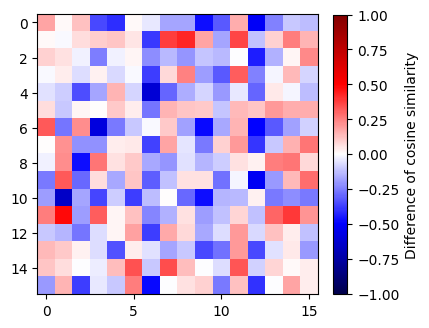

In [ ]:
fig = plt.figure(figsize=(4, 4))
min_val, max_val, mid_val = -1, 1, 0
plt.imshow(diff_sim.cpu(), cmap='seismic', norm=MidpointNormalize(midpoint=mid_val,vmin=min_val, vmax=max_val))
plt.colorbar(label='Difference of cosine similarity', fraction=0.045)
plt.show()

#### 2.2 "Optimal Views Depend on the Downstream Task"

In ["What Makes for Good Views for Contrastive Learning?"](https://proceedings.neurips.cc/paper_files/paper/2020/file/4c2e5eaae9152079b9e95845750bb9ab-Paper.pdf), Tian et al. investigate the impact of the view generation in CL on downstream performance. They formalize how "the amount and type of information shared between [views, denoted as $v_1$ and $v_2$] (i.e., $I(v_1; v_2)$) determines how well we perform on downstream tasks.". Here, $I$ denotes the [mutual information](https://en.wikipedia.org/wiki/Mutual_information). In particular, they consider three situations:

 * Missing information: $I(v_1, v_2) < I(x, y)$, information about the target $y$ contained in the data $x$ has been discarded during the view generation,
  
 * Sweet spot: $I(v_1, v_2) = I(x, y)$, all shared information between $v_1$ and $v_2$ is task-relevant information,

 * Excess noise: $I(v_1, v_2) > I(x, y)$, additional shared information between views is not relevant for the downstream task, which "can lead to worse generalization".

Unsurprisingly, the best view generation (*i.e.* for extracting the most relevant features) depends on the downstream task. In order to further study how the choice of the view generation impacts the downstream performance in practice, authors have designed a toy dataset called Colorful Moving-MNIST (illustrated below). It consists of images with three factors of variation: the class of the background, the class of the digit, the position of the digit.

<center>
    <img src="figures/colorful_moving_mnist.png" alt="colorful moving mnist" width=800>
</center>
<center>
    Illustration of the Colorful-Moving-MNIST dataset. In this example, the first view $v_1$ is a sequence  of frames containing the moving digit, *e.g.*, $v_1 = x_{1:k}$. The matched second view $v^{+}_2$ share some factor with $x_t$  that $v_1$ can predict, while the unmatched view $v^{−}_2$ does not share factor with $x_t$. Source: <a href="https://proceedings.neurips.cc/paper_files/paper/2020/file/4c2e5eaae9152079b9e95845750bb9ab-Paper.pdf">(Tian et al., 2020)</a>
</center>

On this data set, their experiment consists in pre-training models with different view generations (by controlling which factors are shared between views) and evaluating the downstream performance on three tasks: the classification of the background class, of the digit class, and of the digit position. Results are shown in the Table 2 of the paper. 

We are going to reproduce Table 2 on a simplified toy dataset, that we will call Imagenet-MNIST. It consists of images from our subset of ImageNet with overlapped digits (either 1 or 7). Therefore, there are two factors of variation: the class of the background image, and the class of the digit. The two downstream tasks we consider are the background image classification, and the digit classification.

Update the `ImageNetMnist`class in `datasets.py`, and show some samples.

In [26]:
from datasets import ImageNetMnist, collate_views

In [38]:
shared_feature = 'background' # or  'digit'

if isinstance(shared_feature, list):
    shared_feature = '_'.join(shared_feature)

with open(f'configs/contrastive_training_{shared_feature}.yaml', 'r') as file:
    cfg = yaml.safe_load(file)
    
dataset = ImageNetMnist(
    imagenet_data_folder=cfg['imagenet_data_folder'], 
    imagenet_labels_file=cfg['imagenet_labels_file'], 
    imagenet_classes=cfg['imagenet_classes'], 
    mnist_data_folder=cfg['mnist_data_folder'],
    shared_feature=cfg['shared_feature'])

transform = DataTransformation(cfg)
if cfg['shared_feature'] == 'background' or 'background' in cfg['shared_feature']:
    dataset.transform1 = transform(['random_cropping', 'resize'])
    dataset.transform2 = transform(['gaussian_blur', 'normalize'])
elif cfg['shared_feature'] == 'digit':
    dataset.transform1 = transform(['center_cropping'])
    dataset.transform2 = transform(['normalize'])
else:
    raise ValueError("Shared feature must be background or digit")
    
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=cfg['batch_size'],
    shuffle=True,
    collate_fn=collate_views
)

batch = next(iter(data_loader))
imgs, labels = batch
imgs1 = imgs['view1']
imgs2 = imgs['view2']
imgs = imgs['original']

In [41]:
imgs2.shape

torch.Size([8, 3, 224, 224])

In the figure below, the first row is the original image. The second and third rows are the different views. The views share background information, but no digit information.

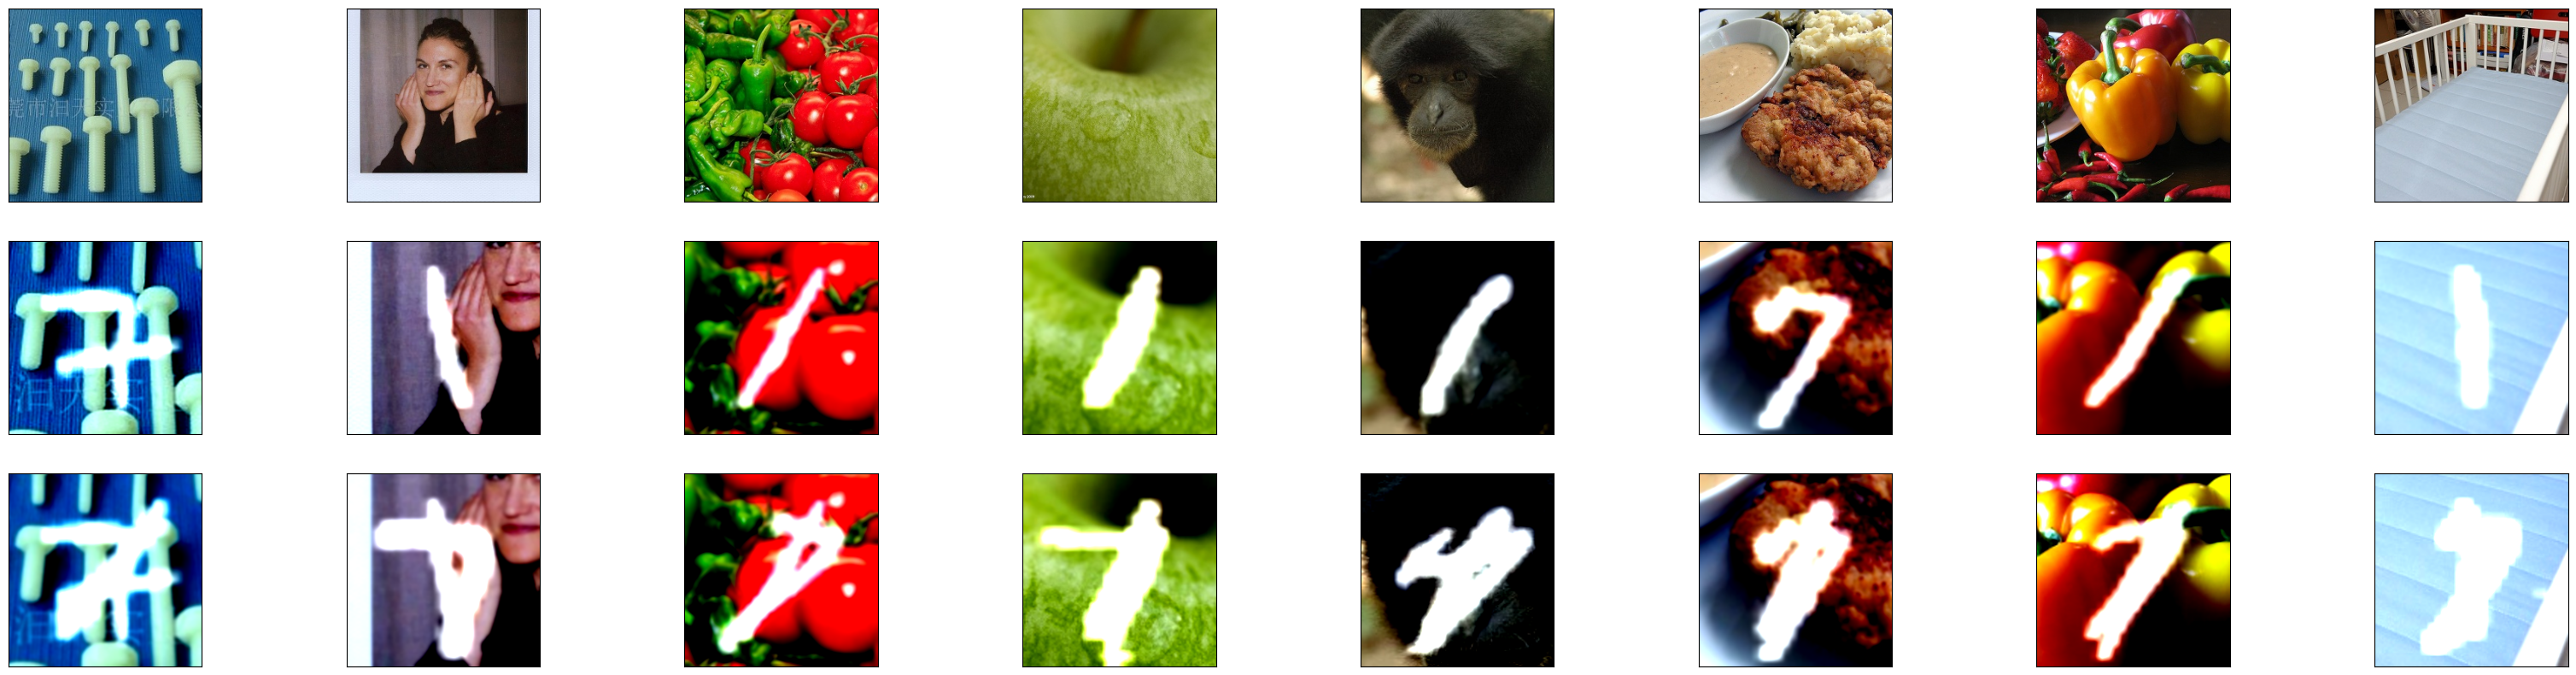

In [39]:
fig, ax = plt.subplots(3, imgs.shape[0], figsize=(40, 10))
for i in range(imgs.shape[0]):
    ax[0, i].imshow(imgs[i].permute(1, 2, 0))
    ax[1, i].imshow(deprocess_image(imgs1[i], cfg['data_mean'], cfg['data_std']))
    ax[2, i].imshow(deprocess_image(imgs2[i], cfg['data_mean'], cfg['data_std']))
    for j in range(3):
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
plt.show()

In [ ]:
from imagenet_mnist_exp import main

In [ ]:
!python imagenet_mnist_training.py --cfg_file configs/contrastive_training_background.yaml

In [ ]:
with open(f'configs/clf_background.yaml', 'r') as file:
    cfg = yaml.safe_load(file)

background_digit = main(cfg,task='digit')
background_image = main(cfg,task='imagenet')

In [ ]:
!python imagenet_mnist_training.py --cfg_file configs/contrastive_training_digit.yaml


In [ ]:
with open(f'configs/clf_digit.yaml', 'r') as file:
    cfg = yaml.safe_load(file)

digit_digit = main(cfg,task='digit')
digit_image = main(cfg,task='imagenet')

In [ ]:
!python imagenet_mnist_training.py --cfg_file configs/contrastive_training_background_digit.yaml


In [ ]:
with open(f'configs/clf_background_digit.yaml', 'r') as file:
    cfg = yaml.safe_load(file)

back_dig_digit = main(cfg,task='digit')
back_dig_image = main(cfg,task='imagenet')

Tsai et al. use a linear projection head to perform the downstream task. We are going to use instead a k-nearest neighbor classifier. Complete the code to run the experiments (`imagenet_mnist_training.py`), train the KNN (`imagenet_mnist_exp.py`) and fill the table below:

| $I(v_1;v_2)$            | digit cls. error rate (%)     |   background cls. error rate (%)   |
| --- | --- | --- |
| digit                   |                               |                                    |
| background              |                               |                                    |
| digit, background       |                               |                                    |
